# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?
- update: I think we should do interp once it's bigger. 

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [min(u,v),max(u,v)]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

# input: G, represented as an adjacency list
# output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
# if target is set to some value, then we instead just output that specific distance
def SSSP(G, target=2):
    dist = [MAX_VTXS for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1)
    labels = torch.tensor(distance1, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data31/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

def vertices_on_shortest_12_path(G, target=2):
    dist = [MAX_VTXS for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size, test=False):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if test else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                if target_vtx > MAX_TUNE_VTXS:
                    continue
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs)
    labels = torch.tensor(distance, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(1000):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

In [4]:
mkbatch(5)

(tensor([[ 1,  2,  5, 12,  3, 12,  2, 11,  9, 12,  2, 10,  1,  7,  1,  2,  9, 10,
           1,  9,  4, 12,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 9, 12,  4,  7,  8, 10,  5, 13,  1, 13,  3, 13,  7, 12,  5,  6,  3,  4,
           6, 13,  2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 1,  5,  8, 12,  2,  9,  2,  7,  5,  9, 10, 11,  6, 10,  4, 12,  1,  2,
           4, 11,  2,  5,  2,  4,  0,  0,  0,  0,  0,  0,  2],
         [ 5,  8,  3,  6,  4,  5,  2,  3,  4,  9,  3,  8,  5,  7,  4,  9,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 6, 13,  1, 13,  1,  4,  6, 13,  5,  7,  2,  4, 10, 12,  4,  6,  8, 11,
           7, 11,  3,  8,  3,  5,  4, 12,  0,  0,  0,  0,  2]]),
 tensor([ 1.,  5.,  1., 15.,  2.]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False,  True,  True,  True,  True,  True,  True,  True,  Tru

(array([523.,   0.,   0.,   0., 390.,   0.,   0.,   0.,   0., 238.,   0.,
          0.,   0.,  92.,   0.,   0.,   0.,   0.,  40.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 743.]),
 array([ 1.     ,  1.21875,  1.4375 ,  1.65625,  1.875  ,  2.09375,
         2.3125 ,  2.53125,  2.75   ,  2.96875,  3.1875 ,  3.40625,
         3.625  ,  3.84375,  4.0625 ,  4.28125,  4.5    ,  4.71875,
         4.9375 ,  5.15625,  5.375  ,  5.59375,  5.8125 ,  6.03125,
         6.25   ,  6.46875,  6.6875 ,  6.90625,  7.125  ,  7.34375,
         7.5625 ,  7.78125,  8.     ,  8.21875,  8.4375 ,  8.65625,
         8.875  ,  9.09375,  9.3125 ,  9.53125,  9.75   ,  9.96875,
        10.1875 , 10.40625, 10.625  , 10.84375, 11.0625 , 11.28125,
        11.5    , 11.7

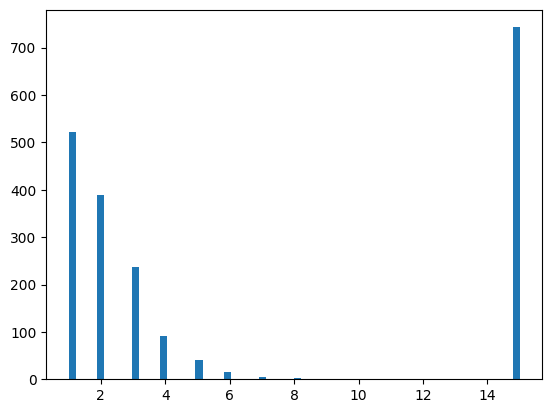

In [5]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1516.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  420.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   94.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   16.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
        1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
        2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
        2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
        3.    , 3.0625, 3.125 , 3.1875, 3.25  , 3.3125, 3.375 , 3.4375,
        3.5   , 3.5625, 3.625 , 3.6875, 3.75  , 3.8125, 3.875 , 3.9375,
        4.    , 4.0625, 4.125 , 4.1875, 4.25  , 4.3125

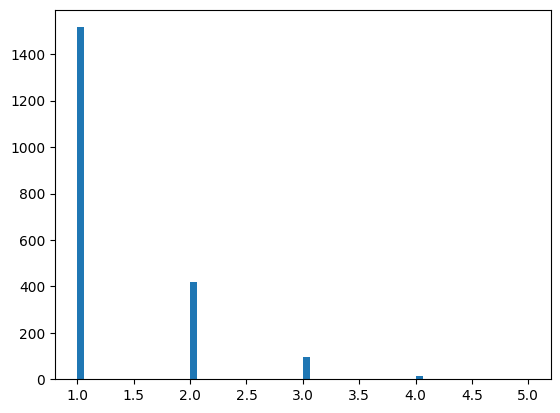

In [6]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

# Step 2: Define Transformer Model

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [7]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 10
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 1048576K
Trainable parameters in the model: 500449


In [8]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [ ]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss = loss.item()
        loss.backward()
        optimizer.step()
        
        train_err.append(train_loss)
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_loss} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")

In [16]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

In [ ]:
with open('training-loss') as f:
    train_err = list(map(float, f.read().split()))
    plt.suptitle('Log MSE vs Epochs')
    plt.plot(torch.log(torch.tensor(train_err)[:500]), label='Train', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Log MSE')
    plt.show()

plt.suptitle('Log MSE vs Epochs')
plt.plot(torch.log(torch.tensor(train_err)), label='Train', color='blue')
plt.plot(torch.log(torch.tensor(len1)).to(torch.float16), label='Len 1', color='red')
plt.plot(torch.log(torch.tensor(len2)).to(torch.float16), label='Len 2', color='green')
plt.plot(torch.log(torch.tensor(len3)).to(torch.float16), label='Len 3', color='yellow')
plt.plot(torch.log(torch.tensor(len15)).to(torch.float16), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.legend()
plt.show()

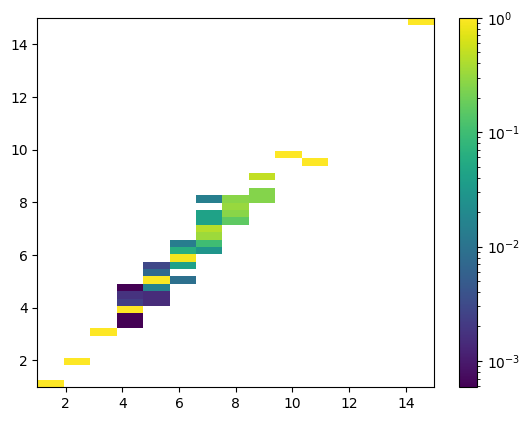

In [11]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.uint8)
y = output.detach()
cnts = torch.bincount(x)
weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
fig, ax = plt.subplots()
h = ax.hist2d(x.cpu().numpy().flatten(), y.to(torch.float16).cpu().numpy().flatten(), weights=weights, bins=[15,50], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.show()

In [10]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

evaluate()

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


0.0005554668023250997

# Step 5: Fine Tune

In [11]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5
TUNE_WD = 0 # 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [15]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch + 1}.pth")

Epoch 0/100 	 Train Err: 0.4553
Epoch 1/100 	 Train Err: 0.2545
Epoch 2/100 	 Train Err: 0.2368
Epoch 3/100 	 Train Err: 0.2138
Epoch 4/100 	 Train Err: 0.1898
Epoch 5/100 	 Train Err: 0.1931
Epoch 6/100 	 Train Err: 0.1948
Epoch 7/100 	 Train Err: 0.1847
Epoch 8/100 	 Train Err: 0.1638
Epoch 9/100 	 Train Err: 0.1490
Epoch 10/100 	 Train Err: 0.1457
Epoch 11/100 	 Train Err: 0.1509
Epoch 12/100 	 Train Err: 0.1537
Epoch 13/100 	 Train Err: 0.1472
Epoch 14/100 	 Train Err: 0.1369
Epoch 15/100 	 Train Err: 0.1304
Epoch 16/100 	 Train Err: 0.1257
Epoch 17/100 	 Train Err: 0.1201
Epoch 18/100 	 Train Err: 0.1160
Epoch 19/100 	 Train Err: 0.1064
Epoch 20/100 	 Train Err: 0.1026
Epoch 21/100 	 Train Err: 0.0964
Epoch 22/100 	 Train Err: 0.1165
Epoch 23/100 	 Train Err: 0.0990
Epoch 24/100 	 Train Err: 0.0691
Epoch 25/100 	 Train Err: 0.0633
Epoch 26/100 	 Train Err: 0.0552
Epoch 27/100 	 Train Err: 0.0505
Epoch 28/100 	 Train Err: 0.0429
Epoch 29/100 	 Train Err: 0.0376
Epoch 30/100 	 Train

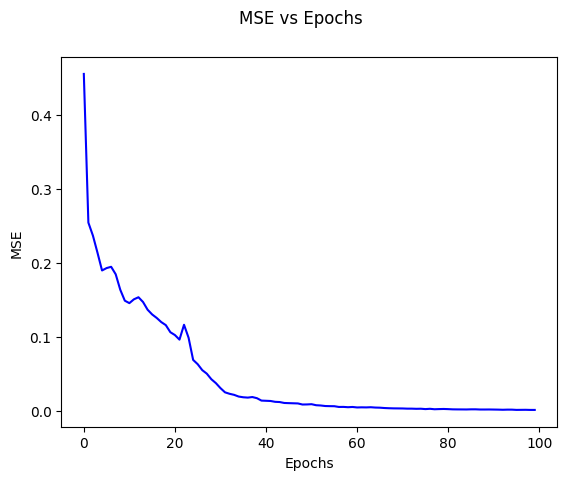

In [17]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [19]:
def tune_evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

tune_evaluate()

0.001733972690999508

(array([[6.0290e+03, 1.8597e+04, 8.4000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]]),
 array([1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  , 1.699, 1.8  ,
        1.9  , 2.   , 2.1  , 2.2  , 2.3  , 2.398, 2.5  , 2.6  , 2.7  ,
        2.8  , 2.898, 3.   , 3.1  , 3.2  , 3.299, 3.398, 3.5  , 3.6  ,
        3.7  , 3.799, 3.898, 4.   , 4.1  , 4.2  , 4.297, 4.4  , 4.5  ,
        4.6  , 4.7  , 4.797, 4.9  , 5.   , 5.098, 5.2  , 5.3  , 5.4  ,
        5.5  , 5.598, 5.7  , 5.797, 5.9  , 6.   ], dty

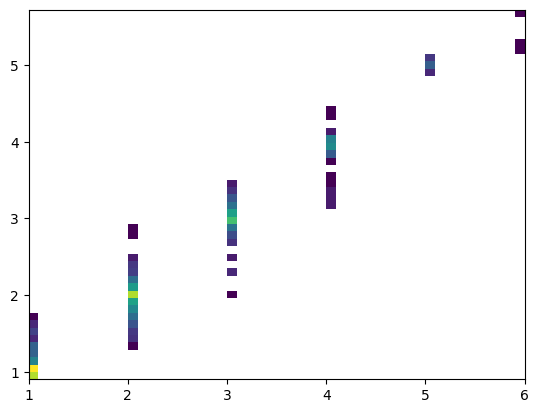

In [21]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 6: Test generalization

0.20130713284015656


(array([[1.7789e+04, 6.5000e+02, 4.8000e+02, ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([ 1.   ,  1.18 ,  1.36 ,  1.54 ,  1.721,  1.9  ,  2.08 ,  2.262,
         2.441,  2.621,  2.8  ,  2.98 ,  3.16 ,  3.34 ,  3.521,  3.701,
         3.88 ,  4.062,  4.242,  4.42 ,  4.6  ,  4.78 ,  4.96 ,  5.14 ,
         5.32 ,  5.5  ,  5.68 ,  5.863,  6.043,  6.223,  6.402,  6.582,
         6.76 ,  6.94 ,  7.12 ,  7.3  ,  7.48 ,  7.66 ,  7.844,  8.02 ,
         8.2  ,  8.38 ,  8.56 ,  8.74 ,  8.92 ,  

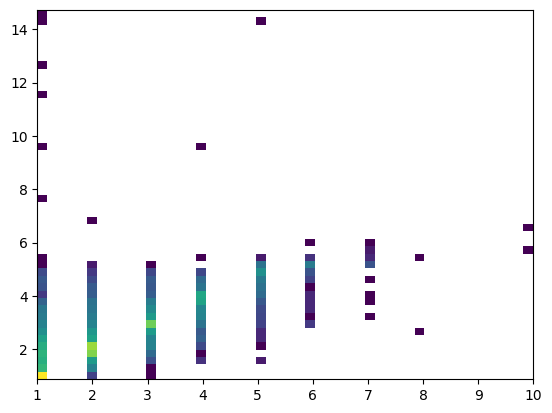

In [27]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ, test=True))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
print(criterion(output.squeeze(1), batch_labels).item())
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())